# Step 1: Basic Data Exploration

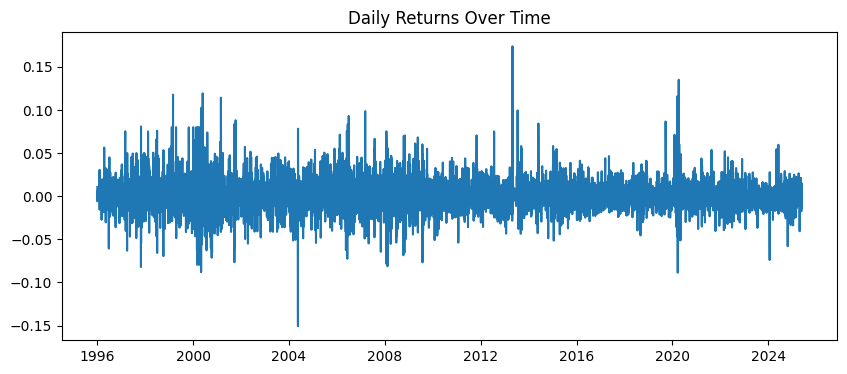

,Open,Close,DailyReturn
count,7383.000000,7383.000000,7383.000000
mean,725.077446,724.718293,0.000735
std,849.900878,849.371362,0.018083
min,34.623829,34.733078,-0.150830
25%,121.953276,121.896919,-0.008642
50%,209.750345,209.750565,0.000000
75%,1153.743220,1151.784485,0.009354
max,2997.242273,3005.728027,0.173821


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("dataFiles/HINDUNILVR_cleaned.csv")
df = df[['Date','Open','Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df['DailyReturn'] = df['Close'].pct_change()
df.dropna(inplace=True)

# Visualize returns
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['DailyReturn'], label="Daily Return")
plt.title("Daily Returns Over Time")
plt.show()

df.describe()

# Step 2: RNN on DailyReturn

Epoch 1/10


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0079
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0040
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0032
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0033
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step


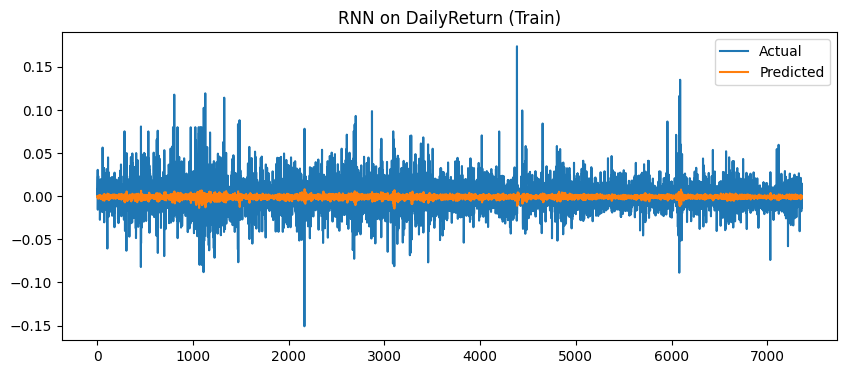

In [2]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
import numpy as np

returns = df['DailyReturn'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_returns = scaler.fit_transform(returns)

# Sequence preparation
def create_sequences(data, seq_len=20):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len])
    return np.array(X), np.array(y)

X_rnn, y_rnn = create_sequences(scaled_returns)

# Build model
model1 = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(X_rnn.shape[1], 1)),
    Dense(1)
])
model1.compile(optimizer='adam', loss='mse')
model1.fit(X_rnn, y_rnn, epochs=10, batch_size=32, verbose=1)

# Prediction
y_pred_scaled = model1.predict(X_rnn)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_true = scaler.inverse_transform(y_rnn)

plt.figure(figsize=(10,4))
plt.plot(y_true, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.title("RNN on DailyReturn (Train)")
plt.legend()
plt.show()

# Step 3: GARCH Volatility Estimation

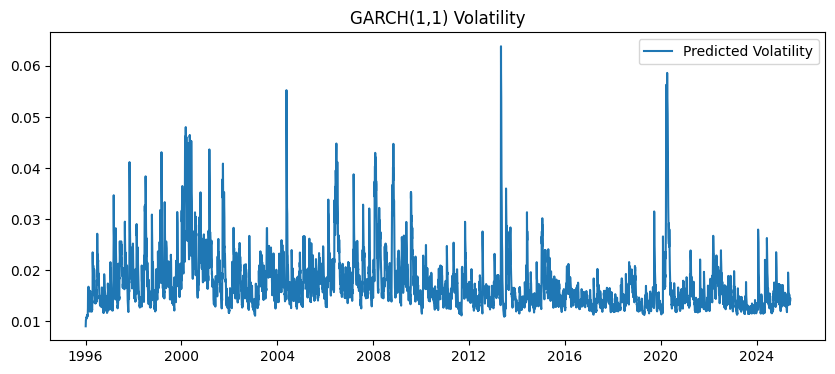

In [3]:
from arch import arch_model

returns_garch = df['DailyReturn'] * 100  # GARCH expects percentage scale
returns_garch = returns_garch.dropna()

model = arch_model(returns_garch, vol='Garch', p=1, q=1)
garch_fitted = model.fit(disp='off')
garch_vol = garch_fitted.conditional_volatility / 100  # bring back to original scale

plt.figure(figsize=(10,4))
plt.plot(df['Date'].iloc[-len(garch_vol):], garch_vol, label='Predicted Volatility')
plt.title("GARCH(1,1) Volatility")
plt.legend()
plt.show()

# Step 4: RNN on DailyReturn / Volatility

Epoch 1/10


/Users/ankuryadav/Downloads/data-iitm/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0053
Epoch 2/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038
Epoch 3/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 4/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0039
Epoch 5/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038
Epoch 6/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
Epoch 7/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 8/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0035
Epoch 9/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0038
Epoch 10/10
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0037
231/231 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


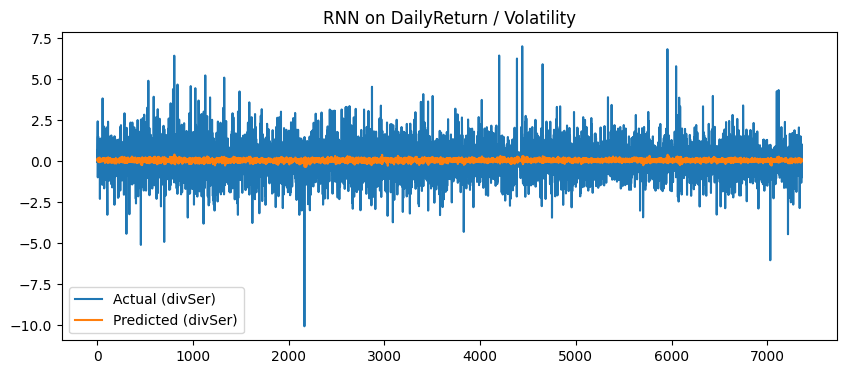

In [4]:
# Drop extra rows to align series
min_len = min(len(garch_vol), len(df['DailyReturn']))
divSer = (df['DailyReturn'].iloc[-min_len:].values / garch_vol.values).reshape(-1, 1)

scaler2 = MinMaxScaler()
scaled_divSer = scaler2.fit_transform(divSer)

X_div, y_div = create_sequences(scaled_divSer)

model2 = Sequential([
    SimpleRNN(50, activation='tanh', input_shape=(X_div.shape[1], 1)),
    Dense(1)
])
model2.compile(optimizer='adam', loss='mse')
model2.fit(X_div, y_div, epochs=10, batch_size=32, verbose=1)

y_pred_scaled2 = model2.predict(X_div)
y_pred2 = scaler2.inverse_transform(y_pred_scaled2)
y_true2 = scaler2.inverse_transform(y_div)

plt.figure(figsize=(10,4))
plt.plot(y_true2, label="Actual (divSer)")
plt.plot(y_pred2, label="Predicted (divSer)")
plt.title("RNN on DailyReturn / Volatility")
plt.legend()
plt.show()

# Step 4.5: Reconstruct Predicted DailyReturn from divSer

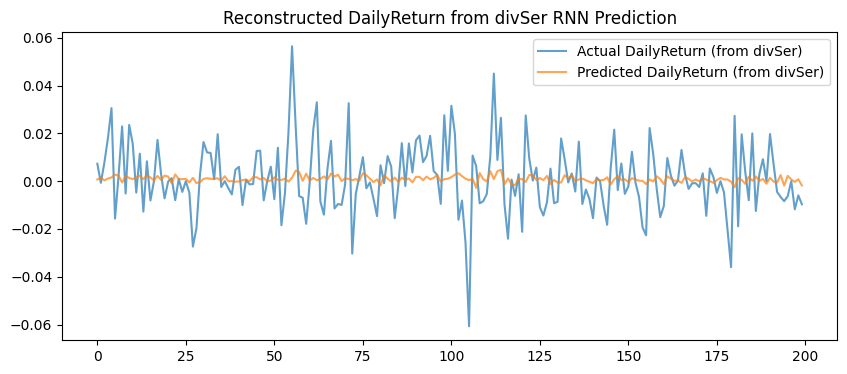

In [5]:
# Step 4.5: Reconstruct DailyReturn from divSer prediction
# Use: predicted_divSer * volatility = predicted_DailyReturn

# Align volatility with divSer predictions
aligned_vol = garch_vol.values[-len(y_pred2):].reshape(-1, 1)

# Multiply to get predicted daily return
predicted_return_from_divSer = y_pred2 * aligned_vol
actual_return_from_divSer = y_true2 * aligned_vol

plt.figure(figsize=(10,4))
plt.plot(actual_return_from_divSer[:200], label="Actual DailyReturn (from divSer)", alpha=0.7)
plt.plot(predicted_return_from_divSer[:200], label="Predicted DailyReturn (from divSer)", alpha=0.7)
plt.title("Reconstructed DailyReturn from divSer RNN Prediction")
plt.legend()
plt.show()

RNN on DailyReturn
MSE: 0.0003312271709141196
MAE: 0.012691346648211031

RNN on DailyReturn / Volatility
MSE: 1.0035632156167633
MAE: 0.7283517752533677


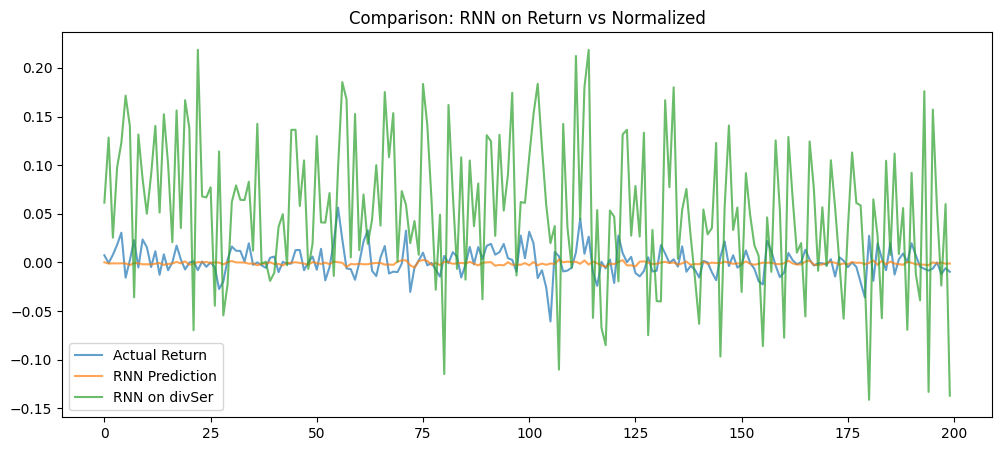

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("RNN on DailyReturn")
print("MSE:", mean_squared_error(y_true, y_pred))
print("MAE:", mean_absolute_error(y_true, y_pred))

print("\nRNN on DailyReturn / Volatility")
print("MSE:", mean_squared_error(y_true2, y_pred2))
print("MAE:", mean_absolute_error(y_true2, y_pred2))

plt.figure(figsize=(12,5))
plt.plot(y_true[:200], label="Actual Return", alpha=0.7)
plt.plot(y_pred[:200], label="RNN Prediction", alpha=0.7)
plt.plot(y_pred2[:200], label="RNN on divSer", alpha=0.7)
plt.title("Comparison: RNN on Return vs Normalized")
plt.legend()
plt.show()